In [1]:
#@title Mount to google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive
!git clone https://github.com/Movelocity/mm-cot.git  # there are some small changes that make the project run
%cd mm-cot
# !du -hs ./*

Cloning into 'mm-cot'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 102 (delta 38), reused 46 (delta 18), pack-reused 28
Receiving objects: 100% (102/102), 1.78 MiB | 14.70 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [2]:
# %cd /content/drive/MyDrive/repo2/mm-cot
# # !git reset --hard
# !git pull https://github.com/Movelocity/mm-cot.git

/content/drive/MyDrive/repo2/mm-cot
From https://github.com/Movelocity/mm-cot
 * branch            HEAD       -> FETCH_HEAD
Already up to date.


## Prepare the model

Try to get the model.zip file to folder mm-cot

https://drive.google.com/file/d/1FtTYOJPHnWnFfCxNC6M3gar4RAX5E21b/view?usp=share_link

If your internet is limited, you can install the **"Copy, URL to Google Drive"** plugin in youre drive.google.com page 

and then open the above link in your browser.

On the top right corner there will be a save_to_drive button.

In [ ]:
# unzip model.zip to folder mm-cot
%cd /content/drive/MyDrive/mm-cot/
!unzip model.zip

# remove __MACOSX folder if you want to save disk space
#!rm -rf /content/drive/MyDrive/mm-cot/__MACOSX

In [ ]:
#@title Install dependencies
!pip install sentence-transformers==2.2.2
!pip install transformers==4.21.1
!pip install timm

In [4]:
#@title UnifiedQA Model
from model import T5ForMultimodalGeneration
from transformers import T5Tokenizer
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

patch_size = (100, 256) # for DETR style
tokenizer = T5Tokenizer.from_pretrained("./models/MM-CoT-UnifiedQA-base-Rationale")
padding_idx = tokenizer._convert_token_to_id(tokenizer.pad_token)
save_dir = "./models/MM-CoT-UnifiedQA-base-Rationale"

model = T5ForMultimodalGeneration.from_pretrained(
    save_dir, patch_size=patch_size, padding_idx=padding_idx, save_dir=save_dir).to(device)

In [5]:
#@title Visual feature extractor (DETR)
from transformers import DetrFeatureExtractor, DetrForObjectDetection

torch.set_grad_enabled(False)
preprocessor = DetrFeatureExtractor.from_pretrained('facebook/detr-resnet-101-dc5')
detection_model = DetrForObjectDetection.from_pretrained('facebook/detr-resnet-101-dc5')
vf_extractor = detection_model.model.to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet101_a1h-36d3f2aa.pth" to /root/.cache/torch/hub/checkpoints/resnet101_a1h-36d3f2aa.pth


### Test the model

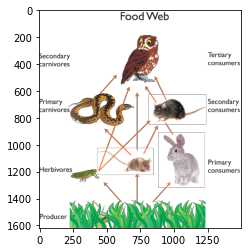

In [23]:
from PIL import Image
import matplotlib.pyplot as plt
import requests

# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
url = 'https://s-media-cache-ak0.pinimg.com/originals/20/5f/f3/205ff3fd8de56d9ef76d0f0da4ee30ea.jpg'
image = Image.open(requests.get(url, stream=True).raw)

plt.figure(figsize=(6,4))
plt.imshow(image)
plt.show()

In [12]:
inputs = preprocessor(images=image, return_tensors="pt")  # dict_keys(['pixel_values', 'pixel_mask'])
vision_tokenizer = vf_extractor(inputs['pixel_values'].to(device), inputs['pixel_mask'].to(device))  # torch.Size([1, 3, 800, 1066]), torch.Size([1, 800, 1066])
torch.save(vision_tokenizer[0], 'visual_tmp_feature.pt')  # Firstly save the vision feature to dist
print(vision_tokenizer[0].shape)  # Do not forget to update current vision feature

torch.Size([1, 100, 256])


In [8]:
def show_result(outputs):
    b = []
    for id in outputs.squeeze().cpu().numpy():
        if id == 29: b += [29]*4
        else: b.append(id)
    c = tokenizer.batch_decode([b], skip_special_tokens=True, clean_up_tokenization_spaces=True)[0].replace('nnnn', '\n')
    print(c)

In [29]:
question = "Question: Based on the arrows, which kind of animal hunts snake? " \
            "Context: There is a food web in the picture, the animal that is pointed is a predator. " \
            "Options: (A) Eagle (B) Owl (C) Rabbit (D) Frog " \
            "Solution:"
input_ids = tokenizer.encode(question, return_tensors="pt").to(device)

outputs = model.generate(input_ids, max_length=512)  # reads the vision feature if file detacted
show_result(outputs)

Solution: A food web is a network of connections that links different parts of an environment. There are many kinds of food webs. You can use these connections to find food.
A food web is a network of connections that links different parts of an environment. There are many ways an organism can get its food. The root of a food web is the food web. It can tell you how an organism is doing.
The color of an arrow tells you the type of arrow. The arrows point to the direction of the arrows. This tells you that the arrows point to the direction of the arrows.
A fox is a mammal. It uses its arrows to catch the fox.
The fox uses its arrows to catch the fox to catch the fox. The arrows point to the fox and the fox. So, the fox hunts snake..


Demostration question format:

"Question: Which of the following could Gordon's test show? 

Context: People can use the engineering-design process to develop solutions to problems. One step in the process is testing if a potential solution meets the requirements of the design. The passage below describes how the engineering-design process was used to test a solution to a problem. Read the passage. Then answer the question below. Gordon was an aerospace engineer who was developing a parachute for a spacecraft that would land on Mars. He needed to add a vent at the center of the parachute so the spacecraft would land smoothly. However, the spacecraft would have to travel at a high speed before landing. If the vent was too big or too small, the parachute might swing wildly at this speed. The movement could damage the spacecraft. So, to help decide how big the vent should be, Gordon put a parachute with a 1 m vent in a wind tunnel. The wind tunnel made it seem like the parachute was moving at 200 km per hour. He observed the parachute to see how much it swung. Figure: a spacecraft's parachute in a wind tunnel. 

Options: (A) if the spacecraft was damaged when using a parachute with a 1 m vent going 200 km per hour (B) how steady a parachute with a 1 m vent was at 200 km per hour (C) whether a parachute with a 1 m vent would swing too much at 400 km per hour 

Solution:"

### Inspect the ScienceQA dataset if you like

In [ ]:
!git clone https://github.com/lupantech/ScienceQA.git

Cloning into 'ScienceQA'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 86 (delta 34), reused 33 (delta 4), pack-reused 0
Unpacking objects: 100% (86/86), 11.28 MiB | 3.60 MiB/s, done.


In [ ]:
from utils_data import img_shape, load_data_img, ScienceQADatasetImg, HParams
import json

config = json.load(open('config.json'))
hps = HParams(**config['rationale_generation'])

problems, qids, name_maps, image_features = load_data_img(hps)

img_features size:  (11208, 100, 256)
number of train problems: 12726

number of val problems: 4241

number of test problems: 4241



In [ ]:
test_set = ScienceQADatasetImg(
            problems, 
            qids['test'], 
            name_maps,
            tokenizer,
            hps.input_len,
            hps.output_len,
            hps,
            image_features,
            hps.test_le,
        )

data_piece = test_set.__getitem__(1)
# return dict{
#   "input_ids": source_ids,
#   "attention_mask": source_mask,
#   "image_ids": image_ids,
#   "labels": target_ids,
# }